### Create clusters of mall customers

#### Import necessary modules and read the file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
mall_customers_data = pd.read_csv("Mall_Customers.csv")

In [3]:
mall_customers_data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

#### Data cleaning, rename columns, check for null values and treat them

In [4]:
mall_customers_data['Annual Income (k$)'] = mall_customers_data['Annual Income (k$)']*1000

In [5]:
mall_customers_data.rename(columns={'Annual Income (k$)':'Annual_Income','Spending Score (1-100)':'Spending_Score'}
                           ,inplace=True)

In [6]:
mall_customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual_Income   200 non-null    int64 
 4   Spending_Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
mall_customers_data.nunique()

CustomerID        200
Gender              2
Age                51
Annual_Income      64
Spending_Score     84
dtype: int64

In [8]:
mall_customers_data.isnull().sum()

CustomerID        0
Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

In [9]:
mall_customers_data.dropna(inplace=True)

In [10]:
mall_customers_data.corr()

,CustomerID,Age,Annual_Income,Spending_Score
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual_Income,0.977548,-0.012398,1.000000,0.009903
Spending_Score,0.013835,-0.327227,0.009903,1.000000


#### The correlation between the features show slight negative correlation between Age and Spending Score. As Age increases, spending score decreases, which is as expected. We can see the same from the bar chart below.

In [11]:
mall_customers_data

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15000,39
1,2,Male,21,15000,81
2,3,Female,20,16000,6
3,4,Female,23,16000,77
4,5,Female,31,17000,40
...,...,...,...,...,...
195,196,Female,35,120000,79
196,197,Female,45,126000,28
197,198,Male,32,126000,74
198,199,Male,32,137000,18


In [12]:
mall_customers_data['Age_deciles'] = pd.qcut(mall_customers_data['Age'], 10, labels = False)

<AxesSubplot:xlabel='Age_deciles'>

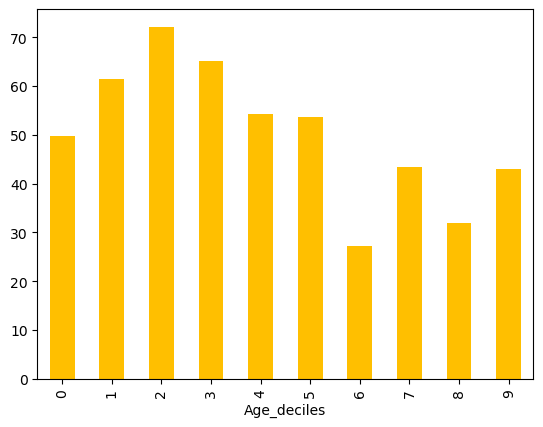

In [13]:
mall_customers_data.groupby('Age_deciles')['Spending_Score'].mean().plot.bar(color='#FFBF00')

#### Exploratory Data Analysis : Generate scatterplot of numeric variables with Gender for stratification

In [14]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Annual_Income",y="Spending_Score", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Annual_Income", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Spending_Score", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

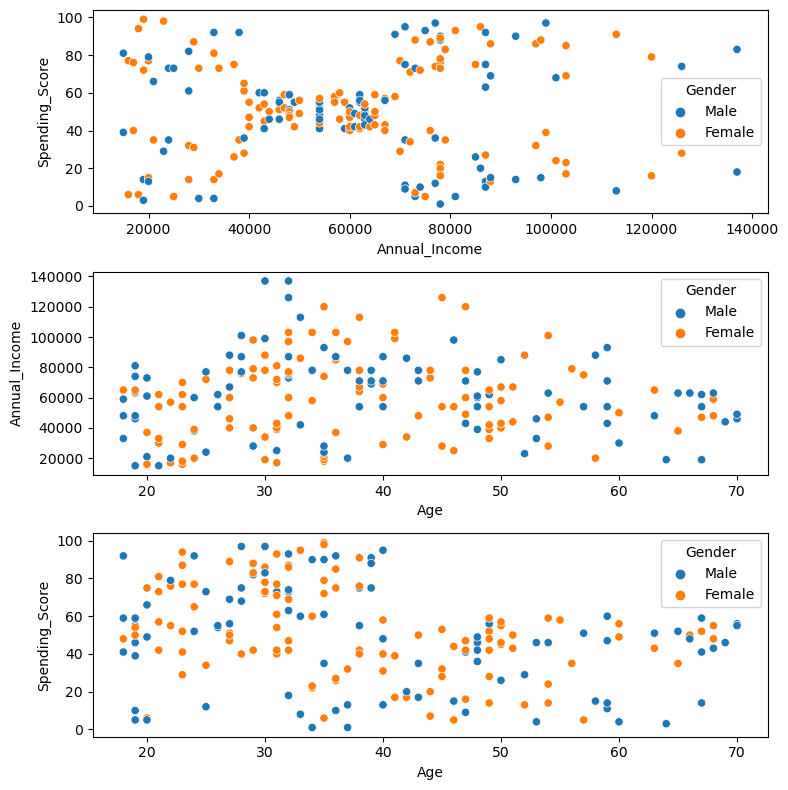

In [15]:
scatters(mall_customers_data, h="Gender")

#### There's no clear trend visible between Annual_Income and Spending_Score and Spending_Score and Age across Gender buckets.As observed earlier, we see Spending_Score reduced for higher Age values

#### Customer segmentation using K-Means clustering:

#### Selecting numeric columns for clusterisation and checking their distribution. If distribution is not normal, the values need to be normalised using transformations. Tried using log, sqrt transformations to see if we get normal distribution of data

In [16]:
cols = ["Age","Annual_Income", "Spending_Score"]
cluster_data = mall_customers_data.loc[:,cols]

In [17]:
def check_distribution(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Annual_Income"], ax=ax2)
    sns.distplot(df["Spending_Score"], ax=ax3)
    plt.tight_layout()

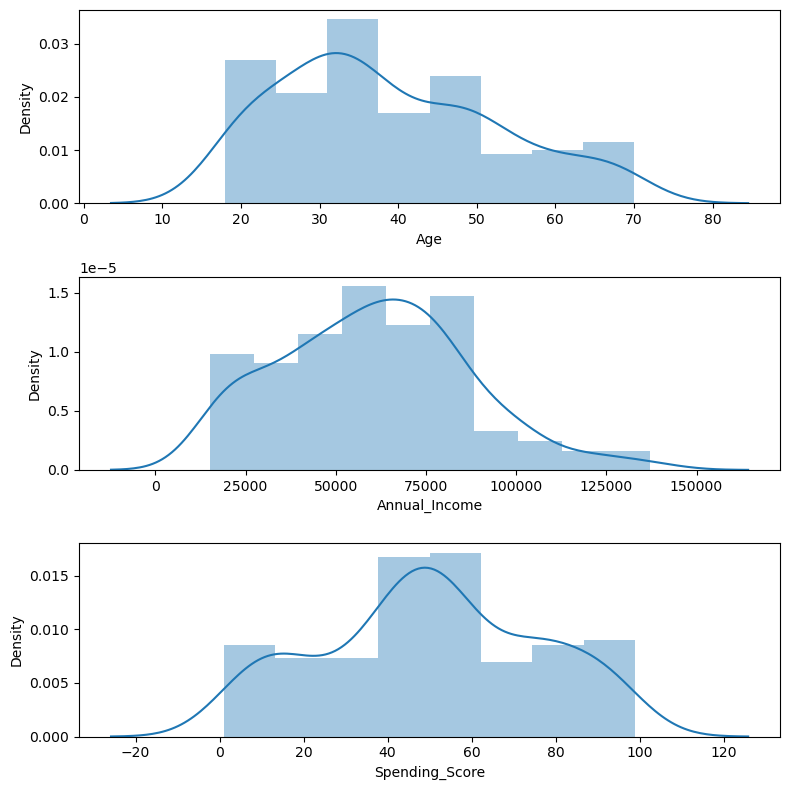

In [18]:
check_distribution(cluster_data)

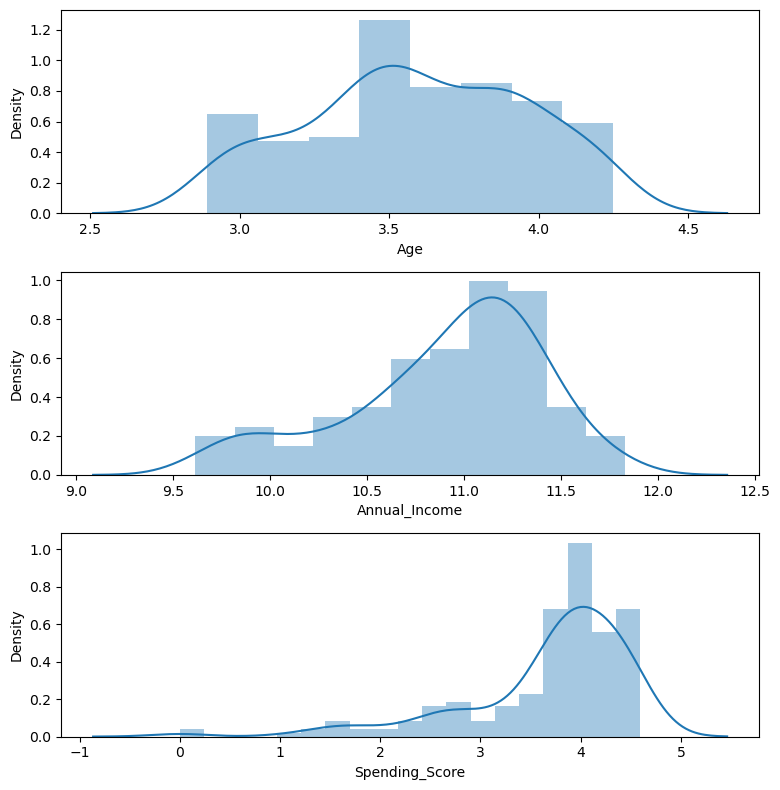

In [19]:
cluster_log = np.log(cluster_data)
check_distribution(cluster_log)

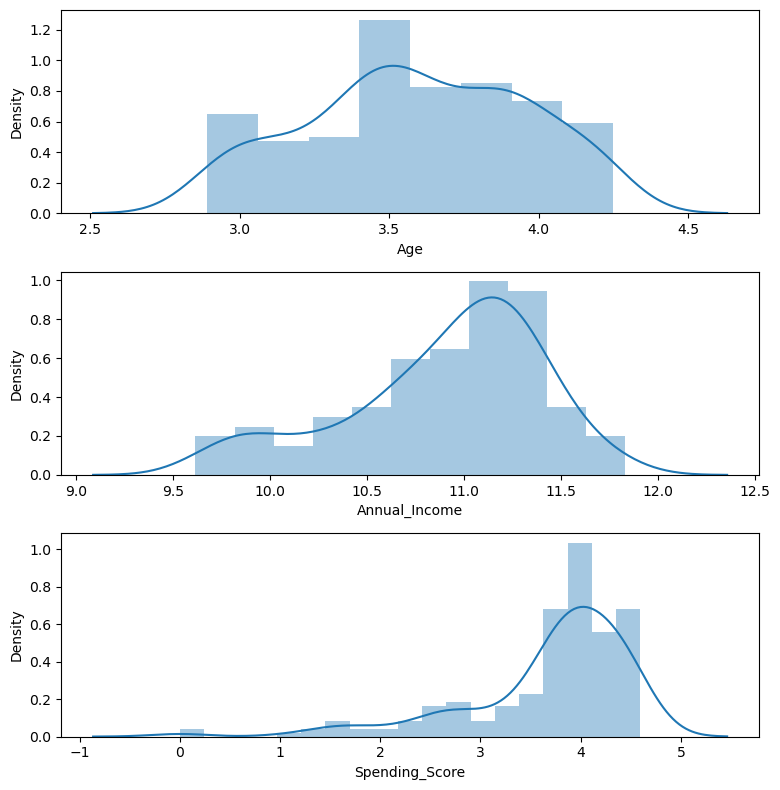

In [20]:
cluster_sqrt = np.sqrt(cluster_data)
check_distribution(cluster_log)

#### cluster_data without any transformations closely follows normal distribution. Applying Standardscaler to get all numeric parameters in same scale

In [21]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

#### Decide number of clusters: 1. Elbow method

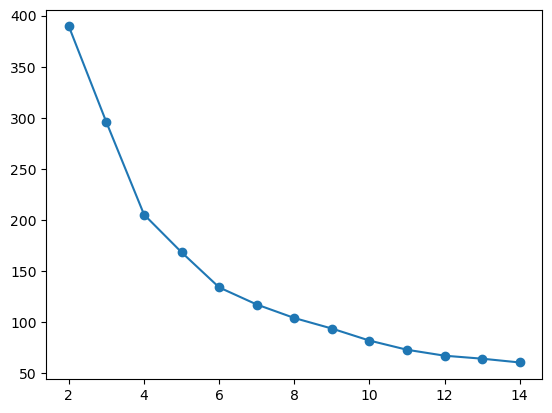

In [22]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

#### The gap between the clusters reduce after 6 points. As per the Elbow method, we can create 6 clusters.

#### Decide number of clusters : 2. Silhouette score method

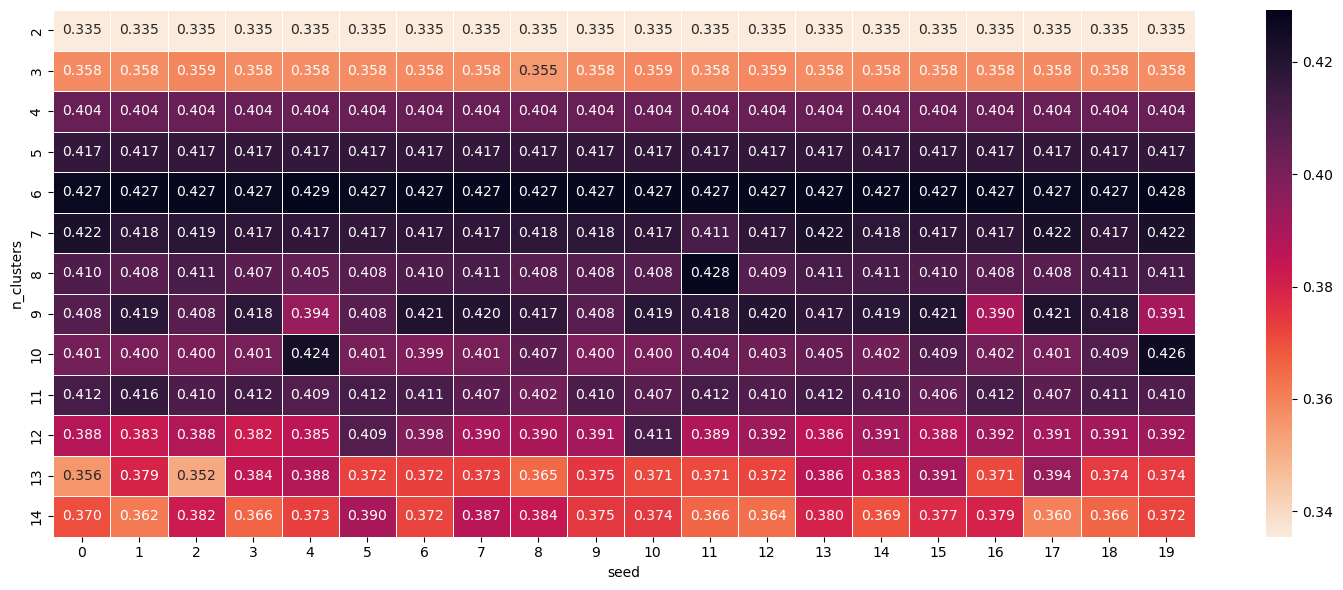

In [23]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

#### The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest score is for 6 clusters and they are relatively insensitive to seed. As per the silhouette score, we can create 6 clustser, as seen in elbow method

#### In order to compare the results, let's choose two cases, one with 5 clusters and another with 6

In [24]:
kmeans_sel = KMeans(n_clusters=5, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data_5_clusters = cluster_data.assign(Cluster_5=labels)

grouped_km = clustered_data_5_clusters.groupby(['Cluster_5']).mean().round(1)
grouped_km['customer_count'] = clustered_data_5_clusters.groupby(['Cluster_5'])['Cluster_5'].count()
grouped_km

,Age,Annual_Income,Spending_Score,customer_count
Cluster_5,,,,
0,25.2,41092.6,62.2,54
1,46.2,26750.0,18.4,20
2,39.9,86102.6,19.4,39
3,55.6,54383.0,48.9,47
4,32.9,86100.0,81.5,40


In [25]:
kmeans_sel = KMeans(n_clusters=6, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data_6_clusters = cluster_data.assign(Cluster_6=labels)

grouped_km2 = clustered_data_6_clusters.groupby(['Cluster_6']).mean().round(1)
grouped_km2['customer_count'] = clustered_data_6_clusters.groupby(['Cluster_6'])['Cluster_6'].count()
grouped_km2

,Age,Annual_Income,Spending_Score,customer_count
Cluster_6,,,,
0,45.5,26285.7,19.4,21
1,32.7,86538.5,82.1,39
2,25.2,25833.3,76.9,24
3,26.7,57578.9,47.8,38
4,41.9,88939.4,17.0,33
5,56.3,54266.7,49.1,45


#### As we see above, 6 clusters can more effectively segment the data than 5 clusters.
- Cluster 0: Medium age bucket, low income, low spending score
- Cluster 1: Medium age bucket, high income, high spending score
- Cluster 2: Low age bucket, low income, high spending score
- Cluster 3: Low age bucket, medium income, medium spending score
- Cluster 4: Medium age bucket, high income, low spending score
- Cluster 5: High age bucket, medium income, medium spending score

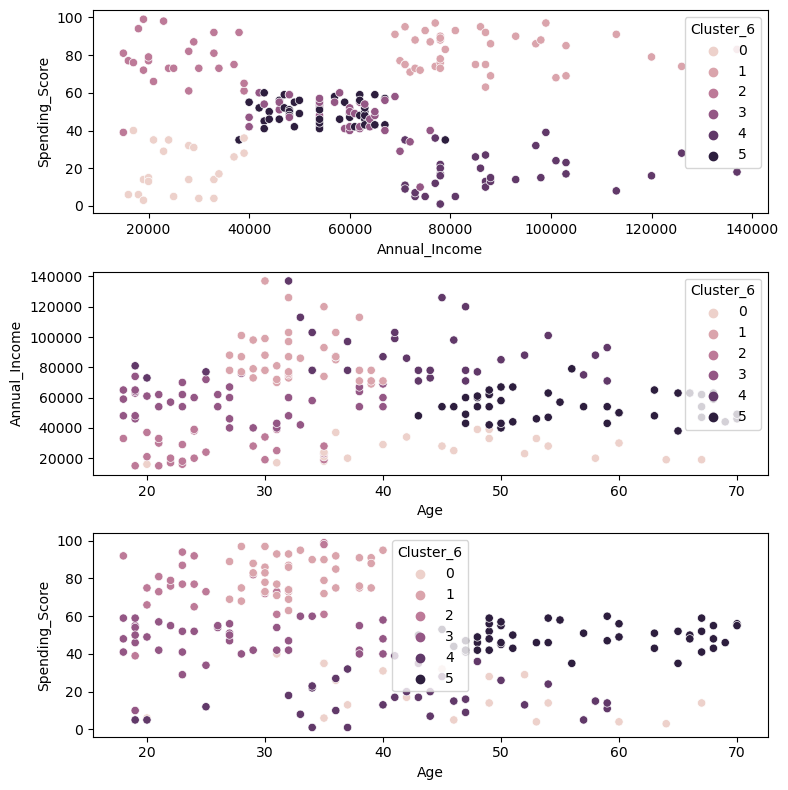

In [27]:
scatters(clustered_data_6_clusters, 'Cluster_6')